In [ ]:
# Split the data 
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.multiclass import  OneVsOneClassifier,OneVsRestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
# Load processed feature matrix and labels
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from skimage.filters import sobel
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import time 

In [450]:
# TODO: Add any util functions you may have from the previous script
digits = load_digits()

# TODO: Load the raw data
X,y = digits.data, digits.target
X=X/16

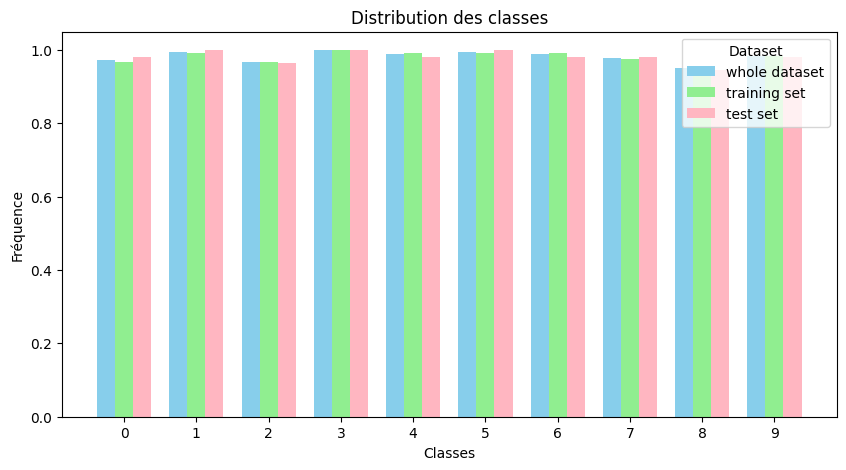

Distance de Bhattacharyya entre les distributions de y_train et y_test : 0.00001


In [451]:
#####
#In machine learning, we must train the model on one subset of data and test it on another.
#This prevents the model from memorizing the data and instead helps it generalize to unseen examples.
#The dataset is typically divided into:
#Training set → Used for model learning.
#Testing set → Used for evaluating model accuracy.
# The training set is also split as a training set and validation set for hyper-parameter tunning. This is done later
#
# Split dataset into training & testing sets


##########################################
## Train/test split and distributions
##########################################


# 1- Split dataset into training & testing sets
# TODO: FILL OUT THE CORRECT SPLITTING HERE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y) 
### If you want, you could save the data, this would be a good way to test your final script in the same evaluation mode as what we will be doing
np.save("X_train.npy", X_train)
np.save("test_data.npy", X_test)
np.save("y_train.npy", y_train)
np.save("test_label.npy", y_test)
####

# TODO: Print dataset split summary...
## demande à giovanni

# TODO: ... and plot graphs of the three distributions in a readable and useful manner (bar graph, either side by side, or with some transparancy)

classes, counts = np.unique(y, return_counts=True)
classes_train, counts_train = np.unique(y_train, return_counts=True)
classes_test, counts_test = np.unique(y_test, return_counts=True)
# Largeur de chaque barre
width = 0.25

# Positions sur l'axe x
x = np.arange(len(classes))
plt.figure(figsize=(10,5))
plt.bar(x - width, counts/max(counts), width=width, color='skyblue', label='whole dataset')
plt.bar(x, counts_train/max(counts_train), width=width, color='lightgreen', label='training set')
plt.bar(x + width, counts_test/max(counts_test), width=width, color='lightpink', label='test set')

plt.xlabel('Classes')
plt.ylabel("Fréquence")
plt.title("Distribution des classes")
plt.xticks(x, classes)  # Affiche les vraies classes sur l'axe x
plt.legend(title='Dataset')
plt.show()


# TODO: (once the learning has started, and to be documented in your report) - Impact: Changing test_size affects model training & evaluation.
def bhattacharyya_distance(p, q, epsilon=1e-10):
    p /= p.sum()
    q /= q.sum()
    bc = np.sum(np.sqrt(p * q))
    # Distance
    return -np.log(bc)

# Comptes de classes
train_counts = np.bincount(y_train)
test_counts = np.bincount(y_test)

# Distributions (probabilités)
train_dist = train_counts / train_counts.sum()
test_dist = test_counts / test_counts.sum()

distance = bhattacharyya_distance(train_dist, test_dist)
print(f"Distance de Bhattacharyya entre les distributions de y_train et y_test : {distance:.5f}")


In [550]:
##########################################
## Prepare preprocessing pipeline
##########################################

# We are trying to combine some global features fitted from the training set
# together with some hand-computed features.
# 
# The PCA shall not be fitted using the test set. 
# The handmade features are computed independently from the PCA
# We therefore need to concatenate the PCA computed features with the zonal and 
# edge features. 
# This is done with the FeatureUnion class of sklearn and then combining everything in
# a Pipeline.
# 
# All elements included in the FeatureUnion and Pipeline shall have at the very least a
# .fit and .transform method. 
#
# Check this documentation to understand how to work with these things 
# https://scikit-learn.org/stable/auto_examples/compose/plot_feature_union.html#sphx-glr-auto-examples-compose-plot-feature-union-py

# Example of wrapper for adding a new feature to the feature matrix
from sklearn.base import BaseEstimator, TransformerMixin

class EdgeInfoPreprocessing(BaseEstimator, TransformerMixin):
    '''A class used to compute an average Sobel estimator on the image
       This class can be used in conjunction of other feature engineering
       using Pipelines or FeatureUnion
    '''
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self # No fitting needed for this processing
    
    def transform(self, X):
        sobel_feature = np.array([np.mean(sobel(img.reshape((8,8)))) for img in X]).reshape(-1, 1)
        return sobel_feature

# TODO: Fill out the useful code for this class
class ZonalInfoPreprocessing(BaseEstimator, TransformerMixin):
    '''A class used to compute zone information on the image
       This class can be used in conjunction of other feature engineering
       using Pipelines or FeatureUnion

       TODO: Continue this work
    '''
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self # No fitting needed for this processing
    
    def transform(self, X):
        zone_features = []
        for img in X:
            img_reshaped = img.reshape(8, 8)
            zone1 = np.mean(img_reshaped[0:4, :])  # lignes 0 à 2
            zone2 = np.mean(img_reshaped[4:6, :])  # lignes 3 à 4
            zone3 = np.mean(img_reshaped[6:9, :])  # lignes 5 à 7
            zone_features.append([zone1, zone2, zone3])
        return np.array(zone_features)
    
class LocalPCAInfoPreprocessing(BaseEstimator, TransformerMixin):
    def __init__(self,n_components=5):
        self.n_components = n_components
        self.pcas = {}  # Dictionnaire des 10 PCA (un par chiffre)

    def GetImages(self,c,target,database):
        pos = np.where(np.array(target) == c)[0]
        label = []
        for i in pos:
            label.append(database[i])
        return np.array(label)

    def fit(self,X,y):
        for i in range(10):
            X_i = self.GetImages(i, y, X)
            pca = PCA(n_components=self.n_components)
            pca.fit(X_i)
            self.pcas[i] = pca
        return self

    def transform(self,X):
        """
        Applique la PCA correspondant à la classe de chaque échantillon.
        Si y est fourni, on transforme chaque x par le PCA de sa classe.
        """
        features = []
        for i, x in enumerate(X):
            label = y[i]
            pca = self.pcas.get(label)
            x_reduced = pca.transform([x])[0]
            features.append(x_reduced)
        return np.array(features)

# TODO: Create a single sklearn object handling the computation of all features in parallel
Pca = PCA(n_components=37)  
F = Pca.fit(X_train,y_train).transform(X_train)

# Let's make sure we have the number of dimensions that we expect!
print("Nb features computed: ", F.shape[1])

# Now combine everything in a Pipeline
# The clf variable is the one which plays the role of the learning algorithms
# The Pipeline simply allows to include the data preparation step into it, to 
# avoid forgetting a scaling, or a feature, or ...

Features= FeatureUnion([ ("pca", Pca),("zonal features",ZonalInfoPreprocessing()), ("edges features",EdgeInfoPreprocessing()),("localPca",LocalPCAInfoPreprocessing())])  #concatenation des 3 features
# Features2 = FeatureUnion([("pca", Pca), ("zonal features",ZonalInfoPreprocessing()), ("edges features",EdgeInfoPreprocessing())])
# TODO: Write your own pipeline, with a linear SVC classifier as the prediction

svm = SVC(kernel='linear',gamma="auto")
clf = Pipeline([("1st scaler", StandardScaler()),("features", Features),("2nd scaler", StandardScaler()), ("classifier", svm)])



Nb features computed:  37


Accuracy of the SVC on the test set:  0.975925925925926
Accuracy of the SVC on the train set:  1.0
527.0 correctement prédit sur 540


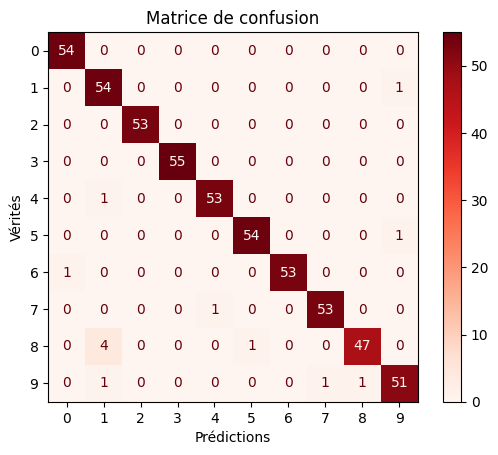


 Question: How does changing test_size influence accuracy?
Try different values like 0.1, 0.3, etc., and compare results.



In [551]:
##########################################
## Premier entrainement d'un SVC
##########################################

# TODO: Train your model via the pipeline

clf.fit(X_train,y_train)

# TODO: Predict the outcome of the learned algorithm on the train set and then on the test set 
predict_test = clf.predict(X_test)
predict_train = clf.predict(X_train)

print("Accuracy of the SVC on the test set: ", sum(y_test==predict_test)/len(y_test))
print("Accuracy of the SVC on the train set: ", sum(y_train==predict_train)/len(y_train))

# TODO: Look at confusion matrices from sklearn.metrics and 
# 1. Display a print of it
print(accuracy_score(y_test, predict_test, normalize=False),"correctement prédit sur",len(y_test))
# 2. Display a nice figure of it
cm = confusion_matrix(y_test, predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.show()


# 3. Report on how you understand the results



# TODO: Work out the following questions (you may also use the score function from the classifier)
print("\n Question: How does changing test_size influence accuracy?")
print("Try different values like 0.1, 0.3, etc., and compare results.\n")



 K-Fold Cross-Validation Results:
- Best Cross-validation score: 0.9888604312907102
- Best parameters found: Pipeline(steps=[('scaler1', MinMaxScaler()),
                ('features',
                 FeatureUnion(transformer_list=[('pca', PCA(n_components=36)),
                                                ('zonal features',
                                                 ZonalInfoPreprocessing()),
                                                ('edges features',
                                                 EdgeInfoPreprocessing()),
                                                ('localPca',
                                                 LocalPCAInfoPreprocessing())])),
                ('scaler2', StandardScaler()),
                ('classifier', SVC(C=5, gamma=0.01))])
Accuracy of the SVC on the test set:  0.987037037037037
Accuracy of the SVC on the train set:  1.0
533.0 correctement prédit sur 540


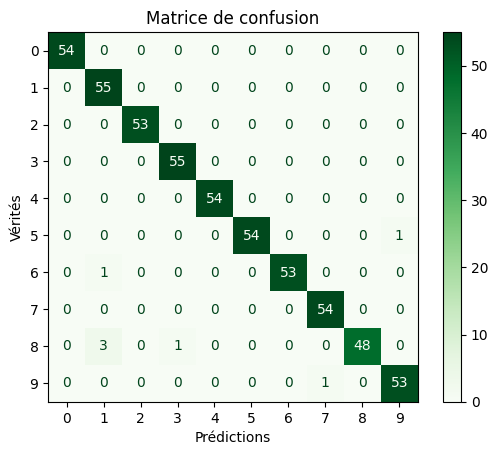


 Question: What happens if we change K from 5 to 10?
Test different K values and compare the accuracy variation.



In [557]:
##########################################
## Hyper parameter tuning and CV
##########################################
svm = SVC(kernel='rbf',gamma="auto")
clf2 = Pipeline([("scaler1", MinMaxScaler()),("features", Features),("scaler2", StandardScaler()), ("classifier", svm)])

# TODO: List all interesting parameters you may want to adapt from your preprocessing and algorithm pipeline

# TODO: Create a dictionary with all the parameters to be adapted and the ranges to be tested

param_grid = {"features__pca__n_components":[34,35,36],"classifier__C": [1,5,9],"classifier__gamma": [0.005,0.01,0.09]}
# TODO: Use a GridSearchCV on 5 folds to optimize the hyper parameters

grid_search = GridSearchCV(clf2, param_grid=param_grid,cv=5,scoring='accuracy')


# Apprentissage sur les données d'entraînement
grid_search.fit(X_train, y_train)    #entraîner le modèle GridSearchCV sur données d’entraînement

# TODO: fit the grid search CV and 
# 1. Check the results
print(" K-Fold Cross-Validation Results:")
print(f"- Best Cross-validation score: {grid_search.best_score_}")
print(f"- Best parameters found: {grid_search.best_estimator_}")

# 2. Update the original pipeline (or create a new one) with all the optimized hyper parameters
best_model = grid_search.best_estimator_
# 3. Retrain on the whol train set, and evaluate on the test set
best_model.fit(X_train,y_train)
# 4. Answer the questions below and report on your findings


# TODO: Predict the outcome of the learned algorithm on the train set and then on the test set 

predict_test3 = best_model.predict(X_test)
predict_train3 = best_model.predict(X_train)

print("Accuracy of the SVC on the test set: ", sum(y_test==predict_test3)/len(y_test))
print("Accuracy of the SVC on the train set: ", sum(y_train==predict_train3)/len(y_train))

# TODO: Look at confusion matrices from sklearn.metrics and 
# 1. Display a print of it
print(accuracy_score(y_test, predict_test3, normalize=False),"correctement prédit sur",len(y_test))
# 2. Display a nice figure of it
cm = confusion_matrix(y_test, predict_test3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.show()

print("\n Question: What happens if we change K from 5 to 10?")
print("Test different K values and compare the accuracy variation.\n")



In [ ]:
## OvO and OvR
##########################################
# TODO: Using the best found classifier, analyse the impact of one vs one versus one vs all strategies
# Analyse in terms of time performance and accuracy

# Print OvO results
model = Pipeline(steps=[('scaler1', MinMaxScaler()),
                ('features',
                 FeatureUnion(transformer_list=[('pca', PCA(n_components=35)),
                                                ('zonal features',
                                                 ZonalInfoPreprocessing()),
                                                ('edges features',
                                                 EdgeInfoPreprocessing())])),
                ('scaler2', StandardScaler()),
                ('classifier', SVC(C=5, gamma=0.013))])

ovo_clf=OneVsOneClassifier(model)

start_ovo = time.time()  # heure de début
ovo_clf.fit(X_train, y_train)  # Entraînement du classifieur OvO
ovo_time = time.time() - start_ovo  # Temps total écoulé



ovo_clf.predict(X_test)

print(" One-vs-One (OvO) Classification:")
print(f"- Test score: {ovo_clf.score(X_test, y_test)}")
print(f"- Number of classifiers trained: {len(ovo_clf.get_params('classifier__estimators_'))}")
print("- Impact: Suitable for small datasets but increases complexity.")
print(ovo_time)
print("\n Question: How does OvO compare to OvR in execution time?")
print("Try timing both methods and analyzing efficiency.\n")



###################
# TODO:  One-vs-Rest (OvR) Classification
ovr_clf = OneVsRestClassifier(model)


start_ovr = time.time()  # heure de début
ovr_clf.fit(X_train, y_train)  # Entraînement du classifieur OvO
ovr_time = time.time() - start_ovr  # Temps total écoulé



ovr_pred = ovr_clf.predict(X_test)


# Print OvR results
print(" One-vs-Rest (OvR) Classification:")
print(f"- Test score: {ovr_clf.score(X_test, y_test)}")
print(f"- Number of classifiers trained: {len(ovr_clf.get_params('classifier__estimators_'))}")
print("- Impact: Better for large datasets but less optimal for highly imbalanced data.")
print(ovr_time)
print("\n Question: When would OvR be better than OvO?")
print("Analyze different datasets and choose the best approach!\n")
########

 One-vs-One (OvO) Classification:
- Test score: 0.9888888888888889
- Number of classifiers trained: 48
- Impact: Suitable for small datasets but increases complexity.
1.1340937614440918

 Question: How does OvO compare to OvR in execution time?
Try timing both methods and analyzing efficiency.

 One-vs-Rest (OvR) Classification:
- Test score: 0.9851851851851852
- Number of classifiers trained: 49
- Impact: Better for large datasets but less optimal for highly imbalanced data.
0.6660048961639404

 Question: When would OvR be better than OvO?
Analyze different datasets and choose the best approach!

